# Altruist Qualitative Experiments

In this notebook we will provide a qualitative experiment using Altruist, on Banknote dataset with 4 different machine learning models and 4 different interpretation techniques.

Load few libraries we will need

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from altruist import Altruist
from fi_techniques import FeatureImportance
import pandas as pd 
import numpy as np
import seaborn as sns
import urllib
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Using TensorFlow backend.


# Banknote Dataset

About Banknote: It is a binary classification problem detecting real or fake banknotes. Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images. 

Attribute Information:

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous) 

Source: https://archive.ics.uci.edu/ml/datasets/banknote+authentication

## Data Loading

Firstly, we load the dataset and we set the feature and class names

In [3]:
banknote_datadset = pd.read_csv('https://raw.githubusercontent.com/Kuntal-G/Machine-Learning/master/R-machine-learning/data/banknote-authentication.csv')
feature_names = ['variance','skew','curtosis','entropy']
class_names=['fake banknote','real banknote'] #0: no, 1: yes #or ['not authenticated banknote','authenticated banknote']

We can plot some instances to see the features and their values

In [4]:
banknote_datadset.head()

,variance,skew,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Moreover, we can use pandas.describe() to see the ranges of each feature. For example, we observe that curtosis's range is -5.286 to 17.927

In [5]:
banknote_datadset.describe()

,variance,skew,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


Then We extract the train data from the dataframe

In [6]:
X = banknote_datadset.iloc[:, 0:4].values 
y = banknote_datadset.iloc[:, 4].values 

In [7]:
len(X)

1372

We have 1372 instances. We are going to use the build-in GridSearch of LionForests to find and train the best classifier for this dataset

## Machine Learning models training step

We will use a MinMax scaler to normalize the input

In [8]:
scaler = MinMaxScaler(feature_range=(-1,1))

We are going to use 4 different classifiers (Random Forests, SVMs, Logistic Regression, Neural Networks

In [9]:
classifiers = {}
scalers = {}

In [10]:
pipe = Pipeline(steps=[('scaler', scaler), ('rf', RandomForestClassifier(random_state=77))])
parameters =[{
    'rf__max_depth': [10],#1, 5, 7, 10
    'rf__max_features': [0.75], #'sqrt', 'log2', 0.75, None
    'rf__bootstrap': [True], #True, False
    'rf__min_samples_leaf' : [1], #1, 2, 5, 10, 0.10
    'rf__n_estimators': [500] #10, 100, 500, 1000
}]
clf = GridSearchCV(pipe, parameters, scoring='f1', cv=10, n_jobs=-1)
clf.fit(X, y)
scaler_rf = clf.best_estimator_.steps[0][1]
rf = clf.best_estimator_.steps[1][1]
classifiers[1] = [rf, str("Random Forests: "+ str(clf.best_score_))]
scalers[1] = scaler_rf

In [11]:
pipe = Pipeline(steps=[('scaler', scaler), ('svm', SVC(probability=True,random_state=77))])
#parameters = [
#  {'svm__C': [-3, 1, 3, 10, 100, 1000], 'svm__kernel': ['linear']},
#  {'svm__C': [-3, 1, 3, 10, 100, 1000], 'svm__gamma': [0.1, 0.01, 0.001, 0.0001], 'svm__kernel': ['rbf']},
#]
parameters = {'svm__C': [100], 'svm__gamma': [0.1], 'svm__kernel': ['rbf']} #best
clf = GridSearchCV(pipe, parameters, scoring='f1', cv=10, n_jobs=-1)
clf.fit(X, y)
scaler_svm = clf.best_estimator_.steps[0][1]
svm = clf.best_estimator_.steps[1][1]
classifiers[2] = [svm, str("SVM: "+ str(clf.best_score_))]
scalers[2] = scaler_svm

In [12]:
pipe = Pipeline(steps=[('scaler', scaler), ('lr', LogisticRegression(random_state=77))])
#parameters = [
#  {'lr__C': [-3, 1, 3, 10, 100, 1000], 'lr__penalty': ['l1'], 'lr__solver': ['liblinear', 'saga']},
#  {'lr__C': [-3, 1, 3, 10, 100, 1000], 'lr__penalty': ['l2'], 'lr__solver': ['newton-cg', 'lbfgs', 'sag','saga']}
#]
parameters = {'lr__C': [3], 'lr__penalty': ['l1'], 'lr__solver': ['liblinear']}#best
clf = GridSearchCV(pipe, parameters, scoring='f1', cv=10, n_jobs=-1)
clf.fit(X, y)
scaler_lr = clf.best_estimator_.steps[0][1]
lr = clf.best_estimator_.steps[1][1]
classifiers[3] = [lr, str("Logistic Regression: "+ str(clf.best_score_))]
scalers[3] = scaler_lr

In [13]:
pipe = Pipeline(steps=[('scaler', scaler), ('nn', MLPClassifier(early_stopping=True, random_state=77))])
#parameters = {
#    'nn__hidden_layer_sizes': [(2,10),(5,10),(10,100),(20,200),(50,500)], 
#    'nn__activation': ['logistic', 'tanh', 'relu'],
#    'nn__solver': ['sgd', 'adam'],
#    'nn__alpha': [0.000001,0.0001,0.001, 0.01, 0.1],
#    'nn__learning_rate': ['constant', 'invscaling', 'adaptive']}
parameters = {
    'nn__hidden_layer_sizes': [(100,1000)], 
    'nn__activation': ['relu'],
    'nn__solver': ['adam'],
    'nn__alpha': [0.0001],
    'nn__learning_rate': ['constant']}
clf = GridSearchCV(pipe, parameters, scoring='f1', cv=10, n_jobs=-1)
clf.fit(X, y)
scaler_nn = clf.best_estimator_.steps[0][1]
nn = clf.best_estimator_.steps[1][1]
classifiers[4] = [nn, str("Neural Network: "+ str(clf.best_score_))]
scalers[4] = scaler_nn

We can see the best classifiers of each algorithm and their scores. In this dataset SVMs work better than the others!

## Qualitative Tests

In [14]:
def arg_tree(untruthful_features, blue_red=True):
    tupls = []
    for i in range(len(untruthful_features[3])):
        tupls.append((untruthful_features[3][i],untruthful_features[2][i]))
        mygraph = nx.DiGraph()
        mygraph.add_edges_from(tupls)
    if not blue_red:
        plt.figure(figsize=(10, 10), dpi=200)
        nx.draw(mygraph, with_labels=True, node_size=1000, arrowsize=15, font_weight='bold', 
            node_color='#54b9eb', rotate=45,
            pos=nx.nx_agraph.graphviz_layout(mygraph,prog='dot', root='A1'))
    else:
        colors_red = []
        colors_blue = []
        flag = True
        new_preds = list(mygraph.predecessors('A1'))
        colors_red.append('A1')
        color_flag = True
        while flag and len(new_preds)>0:
            temp_preds = []
            for pred in new_preds:
                if color_flag:
                    colors_blue.append(pred)
                else:
                    colors_red.append(pred)
                [temp_preds.append(i) for i in list(mygraph.predecessors(pred))]
            if color_flag:
                color_flag = False
            else:
                color_flag = True
            new_preds = temp_preds 
        mygraph = nx.DiGraph()
        mygraph.add_edges_from(tupls)
        plt.figure(figsize=(10, 10), dpi=200)
        G = mygraph
        pos = nx.nx_agraph.graphviz_layout(mygraph,prog='dot', root='A1')
        nx.draw_networkx_nodes(G, pos,
                               nodelist=colors_red,
                               node_color='#eb314d',
                               node_size=500, with_labels=True)
        nx.draw_networkx_nodes(G, pos,
                               nodelist=colors_blue,
                               node_color='#54b9eb',
                               node_size=500,with_labels=True)
        nx.draw_networkx_edges(G, pos, width=1, with_labels=True)

The  ML  models  we  are  selectingare  the  SVM,  which  achieves  the  perfectf1score(100%),  and  the  LR,  which  always  provides  truthfulinterpretation, in order to assess that Altruist will judgethe  interpretations  correctly. 

In [16]:
X_svm = scaler_svm.transform(X)
X_lr = scaler_lr.transform(X)

In [17]:
fi_svm = FeatureImportance(X_svm, y, feature_names, class_names)
fi_lr = FeatureImportance(X_lr, y, feature_names, class_names)

The  SVM  model classified  the  248th banknote  as  fake  with  a  18.55% probability  of  being  real,  while  the  LR  classified  the 942th as real with a probability of 52.99%.

In [52]:
svm.predict_proba(X_svm)[248][1],lr.predict_proba(X_lr)[942][1]

(0.1854645926296569, 0.5299427712095641)

The original interpretations provided  by  LIME  and  PI  for  the  SVM’s  prediction

Text(0.5, 0.98, "Interpretation of SVM's classification")

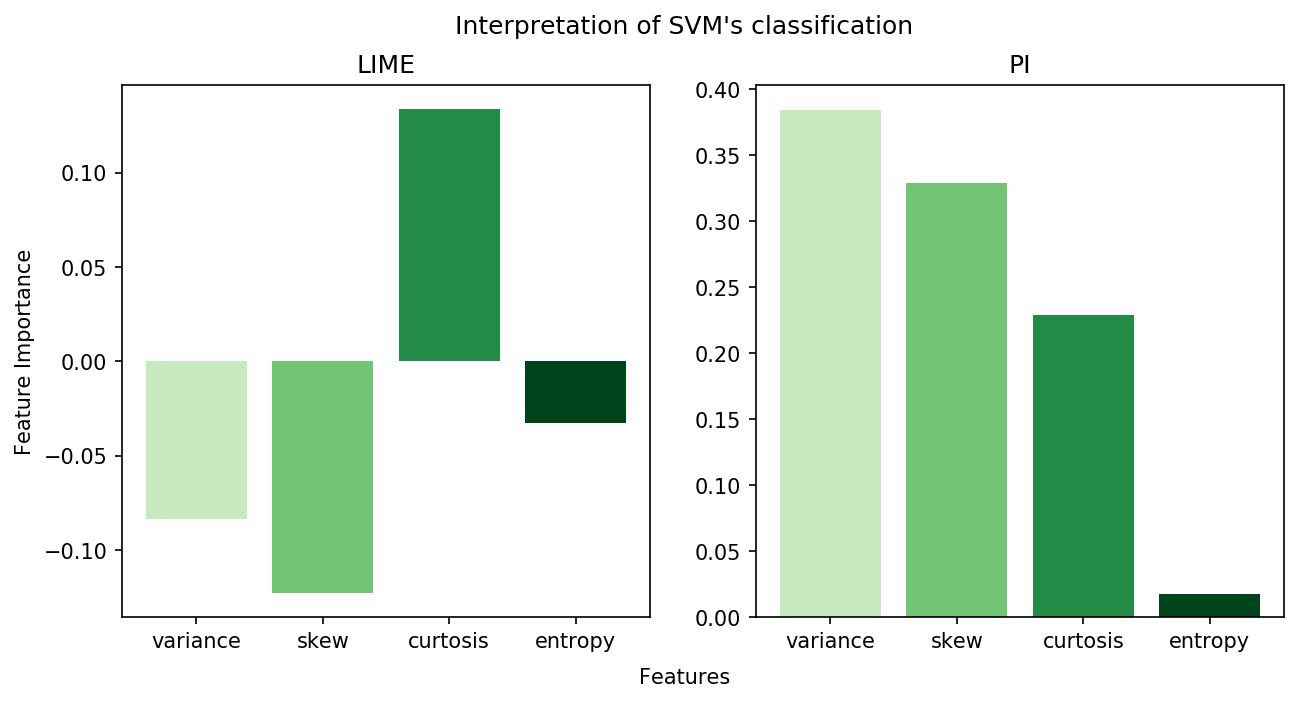

In [53]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

my_cmap = cm.get_cmap('Greens', 17)
my_norm = Normalize(vmin=0, vmax=4)

fig, axs = plt.subplots(1, 2, figsize=(10, 4.7), dpi=150, sharex=True)
axs[0].bar(feature_names, fi_svm.fi_lime(X_svm[248],_,svm),color=my_cmap(my_norm([1,2,3,4])))
axs[0].set_title('LIME')
axs[0].set_ylabel('Feature Importance')

axs[1].bar(feature_names, fi_svm.fi_perm_imp(X_svm[248],_,svm),color=my_cmap(my_norm([1,2,3,4])))
axs[1].set_title('PI')
fig.text(0.5, 0.04, 'Features', ha='center', va='center')
fig.suptitle("Interpretation of SVM's classification")

The LIME’s and the LR’s intrinsic interpretations for the LR’s prediction.

Text(0.5, 0.98, "Interpretation of LR's classification")

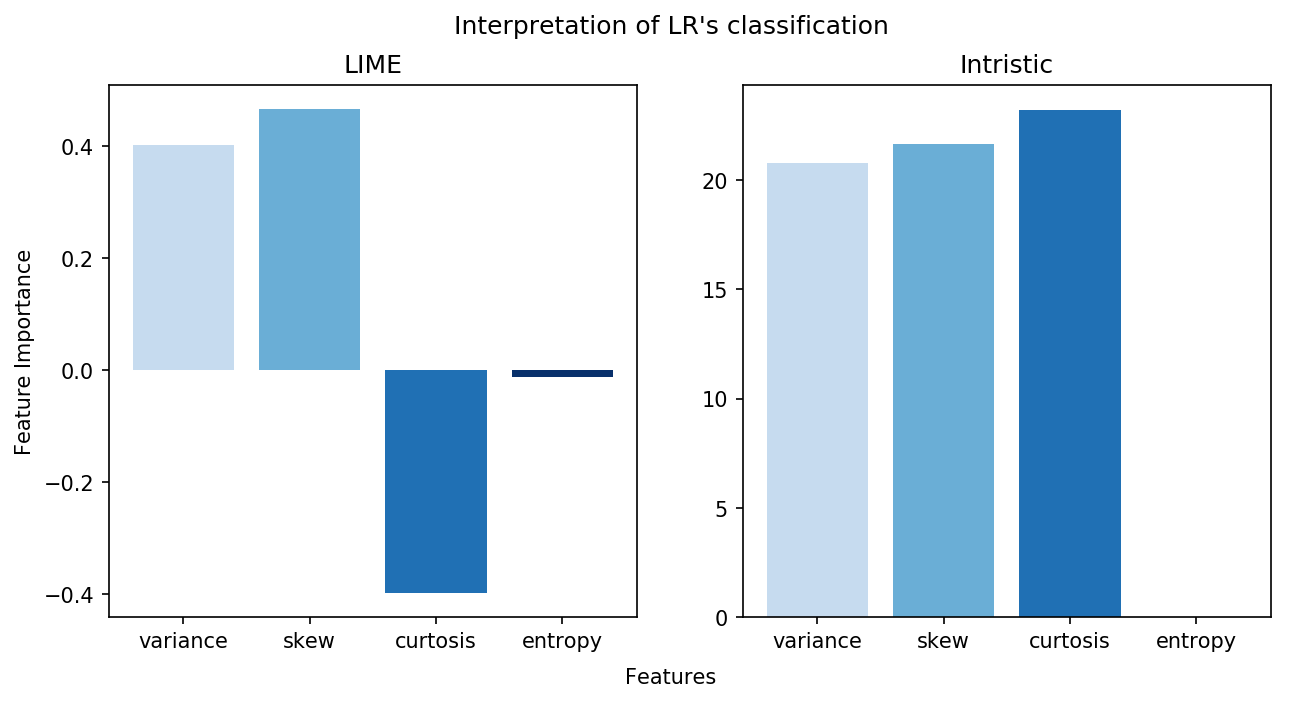

In [40]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

my_cmap = cm.get_cmap('Blues')#plasma
my_norm = Normalize(vmin=0, vmax=4)

fig, axs = plt.subplots(1, 2, figsize=(10, 4.7), dpi=150, sharex=True)
axs[0].bar(feature_names, fi_lr.fi_lime(X_lr[942],_,lr),color=my_cmap(my_norm([1,2,3,4])))
axs[0].set_title('LIME')
axs[0].set_ylabel('Feature Importance')

axs[1].bar(feature_names, fi_lr.fi_coef_lr(X_lr[942],_,lr),color=my_cmap(my_norm([1,2,3,4])))
axs[1].set_title('Intristic')
fig.text(0.5, 0.04, 'Features', ha='center', va='center')
fig.suptitle("Interpretation of LR's classification")

Let's test altruist first for the 248th instance, and then for the 942

In [54]:
@interact(eli_5=True, shap=True, lime=True, perm_importance=True, intristic=True, cl=(1,4), inst=[248,942], counterfactuals = False, explanation=False, only_truthful=False, blue_red=False)
def g(eli_5, shap, lime, perm_importance, intristic, cl, inst, counterfactuals, explanation, only_truthful, blue_red):
    print(classifiers[cl][1])
    X_t = scalers[cl].transform(X)
    fi = FeatureImportance(X_t, y, feature_names, class_names)
    fi_names = {fi.fi_lime:'Lime',fi.fi_shap:'Shap',fi.fi_eli:'Eli5',fi.fi_perm_imp:'Permuation Importance',fi.fi_rf:'Pseudo-Intristic RFs', fi.fi_coef_lr:'Intristic LR'}
    fis = []
    if eli_5 and cl == 1:
        fis.append(fi.fi_eli)
    if lime:
        fis.append(fi.fi_lime)
    if shap:
        fis.append(fi.fi_shap)
    if perm_importance:
        fis.append(fi.fi_perm_imp)
    if intristic and cl == 1:
        fis.append(fi.fi_rf)
    if intristic and cl == 3:
        fis.append(fi.fi_coef_lr)
    fis_scores = []
    for i in fis:
        fis_scores.append([])
        
    print("\nFor a random instance x",X[inst],", the classification was:", classifiers[cl][0].predict_proba(X_t)[inst][1])
    altruistino = Altruist(classifiers[cl][0], X_t, fis, feature_names, None)
    untruthful_features = altruistino.find_untruthful_features(X_t[inst])
    print()
    min_un = 100000
    min_pos = 0
    for i in range(len(fis)):
        print("Untruthful features "+fi_names[fis[i]]+": "+str(untruthful_features[0][i])+" ("+str(len(untruthful_features[0][i]))+")")
        if min_un > len(untruthful_features[0][i]):
            min_un = len(untruthful_features[0][i])
            min_pos = i
    if counterfactuals:
        print("The counterfactuals...",untruthful_features[1][min_pos])
    if explanation:
        print("\nLet's explain the truthfulliest explanation:")
        arg_tree(altruistino.explain_why(X_t[inst],min_pos,truthful_only=only_truthful),blue_red)

interactive(children=(Checkbox(value=True, description='eli_5'), Checkbox(value=True, description='shap'), Che…